In [12]:
using Dates
using NCDatasets
using CairoMakie, Makie
using ColorSchemes
using GeoMakie
using GeoDatasets

"ctroupin-laptop"

In [18]:
if gethostname() == "ctroupin-laptop"
    dirname = "My Passport"
elseif gethostname() == "ULiege" 
    dirname = "T7 Shield"
else
    @error("Unknown host name")
end

datadir = "/media/ctroupin/$(dirname)/CROCO_FILES/run_nea"
grdfile1 = joinpath(datadir, "croco_grd_nea.nc")
grdfile2 = joinpath(datadir, "croco_grd_nea.nc.1")
resfile1 = joinpath(datadir, "T00075.nc")
resfile2 = joinpath(datadir, "T00075.nc.1")
isfile(resfile1) .& isfile(grdfile1)

true

In [19]:
nc = NCDataset(resfile1) 
    T1 = nc["temp"][:,:]
    T1[T1.==0] .= NaN
    time1 = nc["time"][1]
close(nc)
nc = NCDataset(grdfile1) 
    lon1 = nc["lon_rho"][:,:]
    lat1 = nc["lat_rho"][:,:]
close(nc)
nc = NCDataset(resfile2) 
    T2 = nc["temp"][:,:]
    T2[T2.==0] .= NaN
    time2 = nc["time"][1]
close(nc)
nc = NCDataset(grdfile2) 
    lon2 = nc["lon_rho"][:,:]
    lat2 = nc["lat_rho"][:,:]
close(nc)

closed Dataset

In [20]:
dateref = Dates.DateTime(2000, 1, 1)
thedate1 = Dates.format(dateref + Dates.Second(time1), "yyyy-mm-dd HH:MM:SS")
thedate2 = Dates.format(dateref + Dates.Second(time2), "yyyy-mm-dd HH:MM:SS");
@info(thedate1, thedate2)

┌ Info: 2013-03-21 12:04:00
└   thedate2 = "2013-03-21 12:01:20"


In [35]:
typeof(thedate1)

String

In [25]:
using GeoDatasets
# Land/sea mask and coastline
lon_landsea, lat_landsea, landsea = GeoDatasets.landseamask(; resolution = 'f', grid = 1.25)
landsea[landsea.==2] .= 1;
landsea = Float64.(landsea)
landsea[landsea.==0] .= NaN;

coordscoast = GeoDatasets.gshhg("i", 1);

goodlon = findall((lon_landsea .<= maximum(lon1)) .& (lon_landsea .>= minimum(lon1)))
goodlat = findall((lat_landsea .<= maximum(lat1)) .& (lat_landsea .>= minimum(lat1)))
lon_landsea = lon_landsea[goodlon]
lat_landsea = lat_landsea[goodlat]
landsea = landsea[goodlon, goodlat];
# landsea[isnan.(landsea)] .= -999.0;

In [26]:
coastline = GeoMakie.coastlines(10);

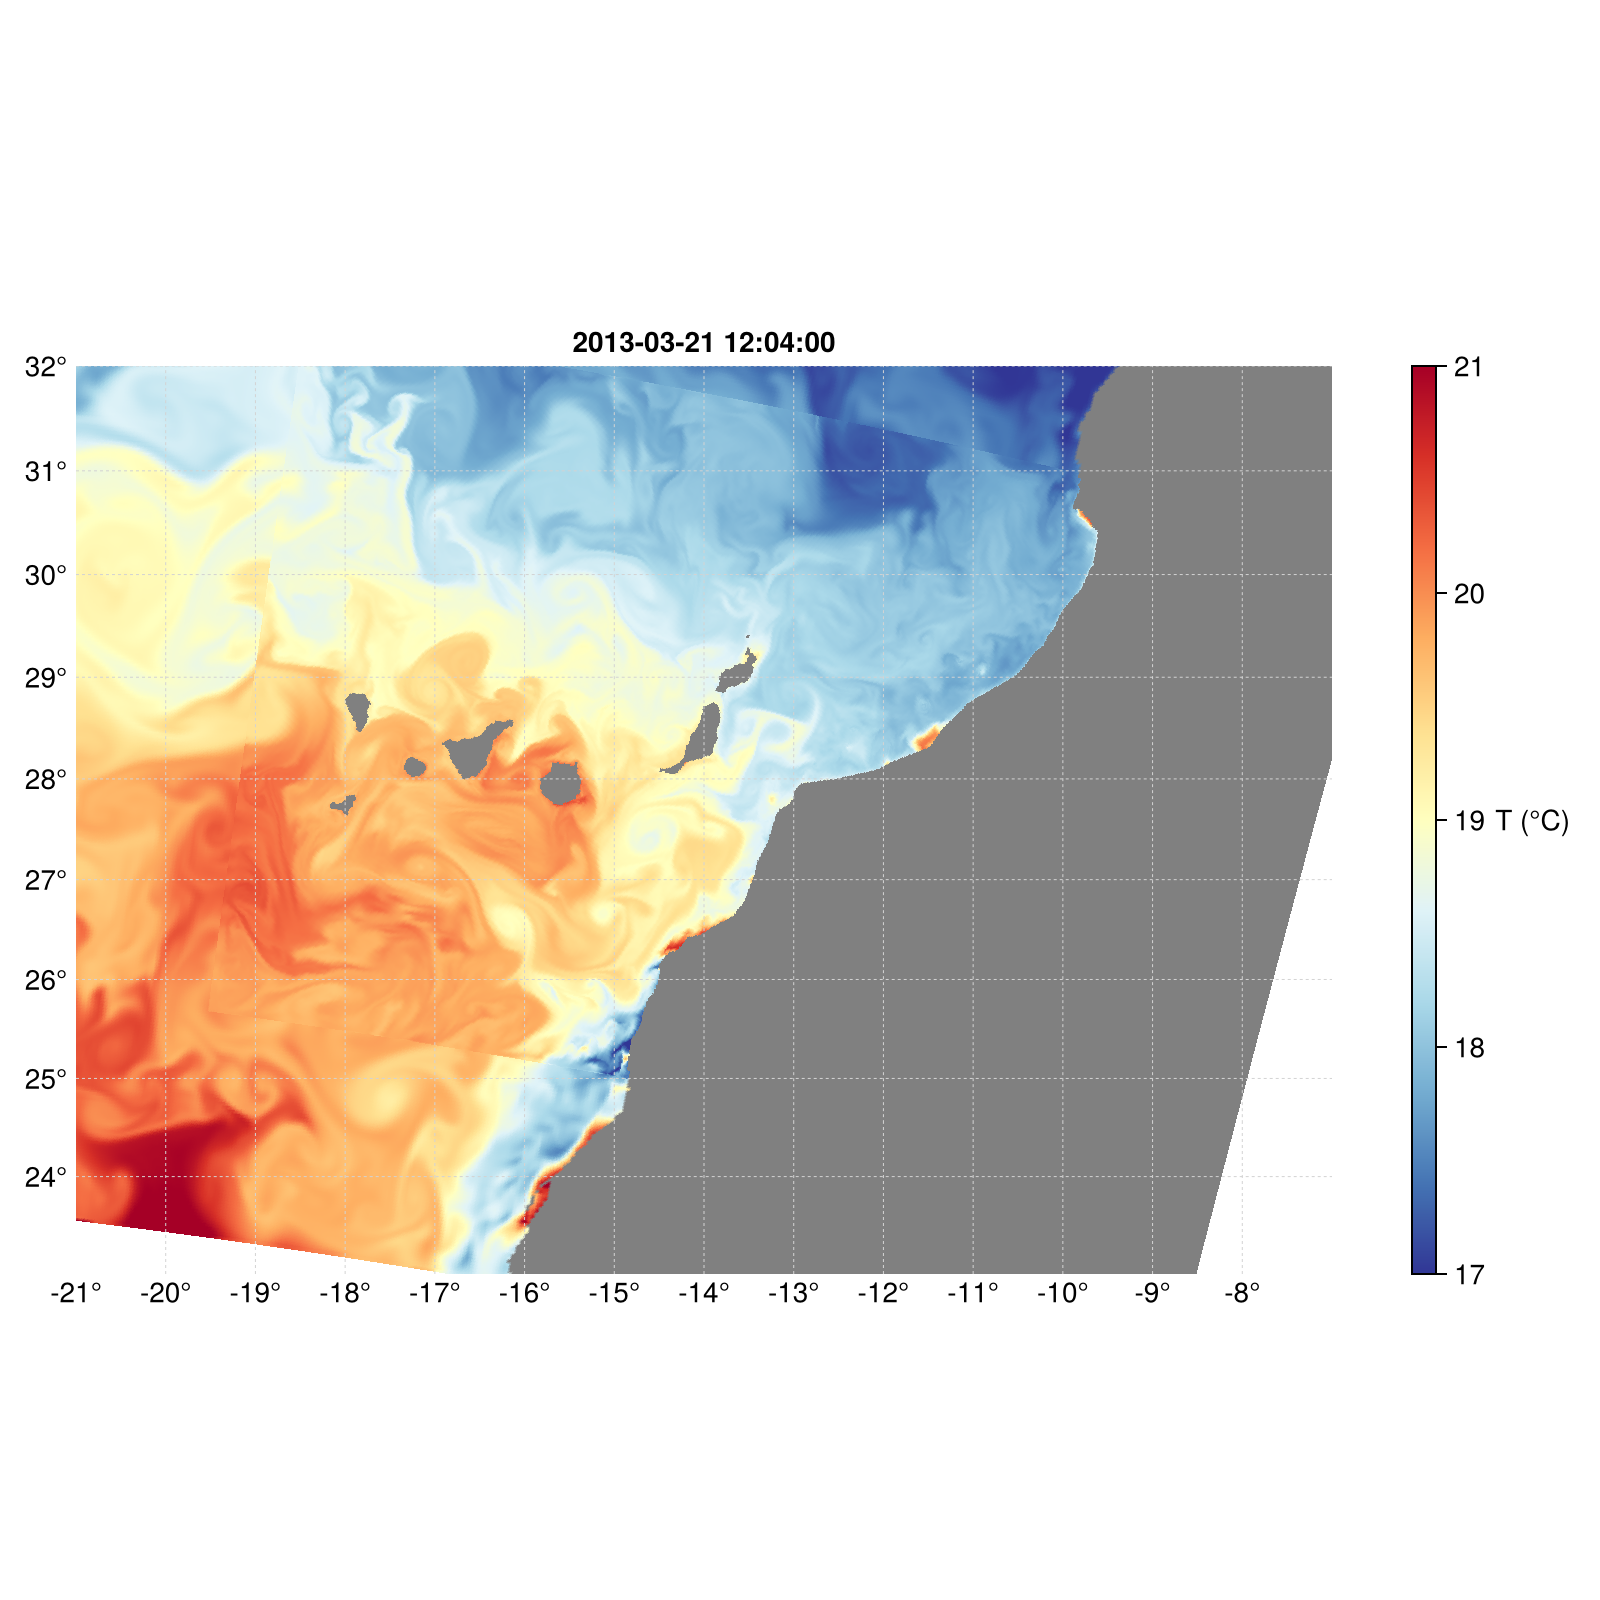

CairoMakie.Screen{IMAGE}


In [38]:
fig = Figure(size=(800, 800))
ax = GeoAxis(fig[1, 1], title=thedate1, dest = "+proj=merc", xgridcolor = :lightgray, 
    xgridwidth = 0.5, xgridstyle = :dash, ygridcolor = :lightgray, 
    ygridwidth = 0.5, ygridstyle = :dash,)

xlims!(ax, -21., -7.)
ylims!(ax, 23., 32.)
sf = surface!(ax, lon1, lat1, zeros(size(lon1)), color=T1,
    colormap = reverse(ColorSchemes.RdYlBu),
    colorrange = [17.0, 21.],
    shading = NoShading,
    nan_color = :gray,
    interpolate = false,)

sf = surface!(ax, lon2, lat2, zeros(size(lon2)), color=T2,
    colormap = reverse(ColorSchemes.RdYlBu),
    colorrange = [17.0, 21.],
    shading = NoShading,
    nan_color = :gray,
    interpolate = false,)
# surface!(ax, lon_landsea, lat_landsea, landsea, colormap = Reverse(:greys))
Colorbar(fig[1, 2], sf, label = "T (°C)", labelrotation = 0, height = @lift($(pixelarea(ax.scene)).widths[2]))
# lines!(ax, coastline; color = :black, linewidth=.25)
# save("croco_avg_20130328.png", fig)
display(fig)